---

**Lesson 9** of the YT course:

[***Machine Learning for Audio Signals in Python - MLfAS***](https://www.youtube.com/playlist?list=PL6QnpHKwdPYjfCH2zkMGEHu2kv1HTICYA)

Original Jupyter Notebooks by [*Renato Profeta*](https://www.youtube.com/c/GuitarsAI)

---

In [1]:
import torch
import torch.nn as nn
import numpy as np
from scipy import signal as sig
import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device) 

device= cpu


#Recurrent Neural Networks

CNN and VAE networks that process the input in layers towards the output, but with no feedback path.

Recurrent Neural Networks (RNN), compute an internal "state" from the input, which then becomes part of the input in the next time-step. This makes it similar to Infinite Impulse Response (IIR) linear filters, which have a feedback path via delay elements from their output back to their input.

We will try to implement it with a Recurrent Neural Network.

To make it function like our IIR filter, we use the hidden states (that represents the output of the RNN) as the delay line in our IIR filter.

NB. We neglected the non-linear activation function and set the biases to zero

###IIR Implementation using RNN 


In [3]:
infeatures= 1 # samples per input time step
hiddensize= 3 #number of hidden states, the memory elements
outputs=1 #1 samples per output time step
numlayers=1 #number of layers of the network
batch=1

In [4]:
#we compute the coefficients for our IIR filter
Fs=8000
omega=2*np.pi*440.0 /Fs; #normalized frequency
Q=0.995 #determines speed of decay, the closer to 1 the longer
k1=2*Q*np.cos(omega)
k2=-pow(Q,2);

In [5]:
#we compute its impulse response and play it to the speaker
seq_len=Fs*2
ximp=np.zeros(seq_len) #make impulse with a desired sequence length
ximp[0]=0.1 #impulse at the beginning
filtered=sig.lfilter([1], np.array([1, -k1,-k2]), ximp)
print("The impulse response sound from the I.I.R. filter")
display(ipd.Audio(filtered, rate= Fs))

The impulse response sound from the I.I.R. filter


In [6]:
class RNNnet(nn.Module):
    def __init__(self, infeatures, hiddensize, outputs):
        super(RNNnet, self).__init__()
        # Define the model.
        self.rnn = nn.RNN(input_size=infeatures, hidden_size=hiddensize, num_layers=numlayers, bias=False)
        #forward layer for output
        self.fo = nn.Linear(hiddensize, outputs, bias=False)
        
    def forward(self, x):
        h_0 = torch.zeros(numlayers, batch, hiddensize).to(device)
        out, hn = self.rnn(x, h_0)
        #Output is simply the hidden state of the last layer (if more than 1 layer)
        out = self.fo(out) #e.g. used to just keep first output
        return out

In [7]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #output: 3-d Pytorch Tensor.
    #for RNN Input: (siglen,batch,features)
    X = np.expand_dims(x, axis=-1) #add batch dimension (here only 1 )
    X = np.expand_dims(X, axis=-1) #add features dimension (here only 1 )
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    return X

In [8]:
#we can create our neural network model and assign our desired weights, such that it acts like the IIR filter
#NB THIS IS NOT THE TRAINING. HERE we configure the RNN to run like an IIR filer
rnn = RNNnet(infeatures, hiddensize, outputs)
#Shifted diagonal matrix and IIR Filter coefficients:
rnn.state_dict()['rnn.weight_hh_l0'].data.copy_(torch.diag(torch.ones(hiddensize-1),diagonal=-1))
rnn.state_dict()['rnn.weight_hh_l0'][0,:].data.copy_(torch.tensor([ k1, k2,0.0]))
#Vector with a "1" for input x:
rnn.state_dict()['rnn.weight_ih_l0'].data.copy_(torch.zeros((hiddensize,1)))
rnn.state_dict()['rnn.weight_ih_l0'][0,0].data.copy_(torch.tensor(1.0))
#Weight for linear output layer to select h[0]:
rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.tensor([1.0,0.0 ,0.0]))
ww = rnn.state_dict() #read obtained weights
print("weights =", ww)

weights = OrderedDict([('rnn.weight_ih_l0', tensor([[1.],
        [0.],
        [0.]])), ('rnn.weight_hh_l0', tensor([[ 1.8724, -0.9900,  0.0000],
        [ 1.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000]])), ('fo.weight', tensor([[1., 0., 0.]]))])


In [10]:
#the input, converted from the Numpy array:
inputsig=signal2pytorch(ximp)
#Run Recurrent Neural Network:
outsig= rnn(inputsig)

The output of the RNN is then converted back to numpy, played back to the speaker for listening comparison, and ploted together with the output of the IIR filter for visual comparison.

In [11]:
outsig=outsig.detach()
outsig=np.array(outsig) #turn into numpy array
outsig=outsig[:,0,0]
print("The sound from the recurrent neural network")
display(ipd.Audio(outsig, rate=Fs))

The sound from the recurrent neural network


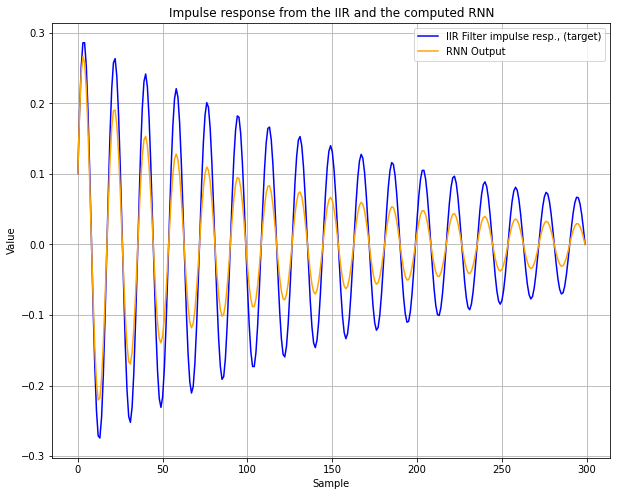

In [12]:
plt.figure(figsize=(10,8))
plt.plot(filtered[:300], 'blue')
plt.plot(outsig[:300],'orange')
plt.legend(('IIR Filter impulse resp., (target)','RNN Output'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title("Impulse response from the IIR and the computed RNN")
plt.grid()

The resulting plot below shows that the output from the RNN is somewhat smaller, because of the tanh function.

#Training the RNN

In general we will not pre-compute the weights, but let the optimization figure it out on its own, given the desired impulse response as target signal.

If the optimization is powerful enough it should be able to find this solution. The problem here is that for a system with feedback, as the RNN, the gradient of the loss function for the optimization is difficult to compute.

Pytorch uses "Autograd" to compute the gradients of the loss function.

In [13]:
#input is the pulse, with the 0.1 in the beginning, target is the output of the IIR filter:
target= signal2pytorch(filtered) #our previus impulse response will be now our target !!
print("target.type()=", target.type())
print("target=", target)

target.type()= torch.FloatTensor
target= tensor([[[ 1.0000e-01]],

        [[ 1.8724e-01]],

        [[ 2.5157e-01]],

        ...,

        [[-2.8209e-36]],

        [[-1.4916e-36]],

        [[ 0.0000e+00]]])


In [14]:
#random starting point as initialization, so NO pre-calculated weights as before:
rnn.state_dict()['rnn.weight_hh_l0'].data.copy_(torch.randn(hiddensize,hiddensize))
#rnn.state_dict()['rnn.weight_hh_l0'].data.copy_(torch.zeros(hiddensize,hiddensize))
rnn.state_dict()['rnn.weight_ih_l0'].data.copy_(torch.randn((hiddensize,1)))
#rnn.state_dict()['rnn.weight_ih_l0'].data.copy_(torch.zeros((hiddensize,1)))
#rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.tensor([ 1.0, 0.0 ,0.0]))
#rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.zeros(hiddensize))
rnn.state_dict()['fo.weight'][0,:].data.copy_(torch.randn(hiddensize))

tensor([ 2.7362,  1.3289, -0.8835])

In [20]:
rnn = RNNnet(infeatures, hiddensize, outputs).to(device)
ww = rnn.state_dict() #read current weights
print("weights =", ww)
print('Total number of parameters: %i' % (sum(p.numel() for p
in rnn.parameters() if p.requires_grad)))
loss_fn = nn.MSELoss(reduction='sum')
#learning_rate = 1e-3
optimizer = torch.optim.Adam(rnn.parameters())
for epoch in range(500):
    Ypred=rnn(inputsig)
    loss=loss_fn(Ypred, target)
    if epoch%10==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

weights = OrderedDict([('rnn.weight_ih_l0', tensor([[ 0.1334],
        [-0.0918],
        [ 0.2255]])), ('rnn.weight_hh_l0', tensor([[ 0.1492,  0.2133, -0.2848],
        [-0.0966,  0.4126,  0.0782],
        [-0.0898, -0.3812, -0.5366]])), ('fo.weight', tensor([[-0.4975, -0.5682,  0.2389]]))])
Total number of parameters: 15
0 4.3863630294799805
10 4.3854899406433105
20 4.384546756744385
30 4.383467674255371
40 4.382148742675781
50 4.380466461181641
60 4.37827205657959
70 4.375359058380127
80 4.371441841125488
90 4.366132736206055
100 4.358959197998047
110 4.349491596221924
120 4.33774471282959
130 4.324920177459717
140 4.31362771987915
150 4.304838180541992
160 4.295790195465088
170 4.285870552062988
180 4.275019645690918
190 4.262424945831299
200 4.2471089363098145
210 4.22726583480835
220 4.199215888977051
230 4.15467643737793
240 4.072322845458984
250 3.8773787021636963
260 3.00785756111145
270 0.7467705011367798
280 0.33856815099716187
290 0.17847001552581787
300 0.10188521444797516

In [21]:
#the input, converted from the Numpy array:
inputsig=signal2pytorch(ximp)
#Run Recurrent Neural Network:
outsig= rnn(inputsig)

In [22]:
outsig=outsig.detach()
outsig=np.array(outsig) #turn into numpy array
outsig=outsig[:,0,0]
print("The sound from the recurrent neural network")
display(ipd.Audio(outsig, rate=Fs))

The sound from the recurrent neural network


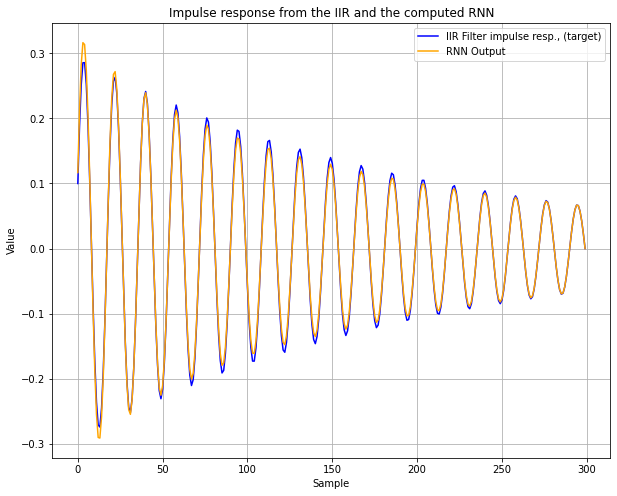

In [23]:
plt.figure(figsize=(10,8))
plt.plot(filtered[:300], 'blue')
plt.plot(outsig[:300],'orange')
plt.legend(('IIR Filter impulse resp., (target)','RNN Output'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title("Impulse response from the IIR and the computed RNN")
plt.grid()

Observe that we now have an even better fit than with our pre-computed weights. This is because the training was able to partly compensate the effects of the non-linear activation function (the tanh).